
a1805	Natalia Beatriz	Diaz

e1401	Martin Nicolas	Duarte

a1822	Cristian Patricio Salinas Talamilla

a1812	Ezequiel Eduardo Maudet

a1819	Manuel Pineyro


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

Unable to revert mtime: /Library/Fonts
Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


# California Housing

Este es un popular [dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) que vamos a estar leyendo desde **Scikit-Learn**.

Se requiere construir una regresión que nos permita predecir el valor de valor medio de casas en distritos de California (medidos en ciento de miles de dólares $100.000). Este dataset deriva del censo de 1990 de EEUU, donde cada observación es un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EE. UU. publica datos de muestra (un bloque típicamente tiene una población de 600 a 3,000 personas).

Un hogar es un grupo de personas que residen dentro de una casa. Dado que el número promedio de habitaciones y dormitorios en este conjunto de datos se proporciona por hogar, estas columnas pueden tomar valores grandes para grupos de bloques con pocos hogares y muchas casas vacías.

Los atributos en el orden que se guardaron en el dataset son:

- `MedInc`: Ingreso medio en el bloque
- `HouseAge`: Edad mediana de las casas en el bloque
- `AveRooms`: Número promedio de habitaciones por hogar.
- `AveBedrms`: Número promedio de dormitorios por hogar.
- `Population`: Población del bloque
- `AveOccup`: Número promedio de miembros por hogar.
- `Latitude`: Latitud del bloque
- `Longitude`: Longitud del bloque

In [16]:
# Leemos el dataset
california_housing = fetch_california_housing()

# Y obtenemos los atributos y target
X = california_housing.data
y = california_housing.target

# Transformamos en Pandas
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos a X e y, esto ayuda a la parte de la gráfica del mapa de calor de correlación
df_california = pd.concat([X, y], axis=1)

In [3]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [5]:
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Se separa el dataset en entrenamiento y evaluación

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

In [7]:
# Escalemos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformemos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=california_housing['feature_names'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=california_housing['feature_names'])

In [8]:
X_train_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.133506,0.509357,0.181060,-0.273850,-0.184117,-0.010825,-0.805682,0.780934
1,-0.532218,-0.679873,-0.422630,-0.047868,-0.376191,-0.089316,-1.339473,1.245270
2,0.170990,-0.362745,0.073128,-0.242600,-0.611240,-0.044800,-0.496645,-0.277552
3,-0.402916,-1.155565,0.175848,-0.008560,-0.987495,-0.075230,1.690024,-0.706938
4,-0.299285,1.857152,-0.259598,-0.070993,0.086015,-0.066357,0.992350,-1.430902


Aquí se muestra un ejemplo de validación cruzada.

- Usamos método de 5-folds
- Usamos el MSE. [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) usa el valor negativo por motivos de simplificar el funcionamiento de otras funciones de la libreria.

In [9]:
# Creamos un modelo
alpha = 1.0
ridge_model = Ridge(alpha=alpha)

# Este la forma que se implementa en scikit-learn
cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)

# Este calculo nos devuelve el valor de MSE para cada una de los folds
cv

array([-0.54786366, -0.5008472 , -0.52047089, -0.51611229, -0.54882174])

In [10]:
# Podemos obtener el valor medio y desvio estandar de cada caso:
print(f"La media del MSE en 5-fold CV para la regresión Ridge con alpha={alpha} es {(-1)*cv.mean()}")
print(f"El desvío estándar del MSE en 5-fold CV para la regresión Ridge con alpha={alpha} es {cv.std()}")

La media del MSE en 5-fold CV para la regresión Ridge con alpha=1.0 es 0.5268231539349311
El desvío estándar del MSE en 5-fold CV para la regresión Ridge con alpha=1.0 es 0.018742809748334602


In [11]:
# Acá generamos varios valores de alpha para la búsqueda pedida en el TP.

In [12]:
alpha_values = np.linspace(0, 12.5, 100)
alpha_values

array([ 0.        ,  0.12626263,  0.25252525,  0.37878788,  0.50505051,
        0.63131313,  0.75757576,  0.88383838,  1.01010101,  1.13636364,
        1.26262626,  1.38888889,  1.51515152,  1.64141414,  1.76767677,
        1.89393939,  2.02020202,  2.14646465,  2.27272727,  2.3989899 ,
        2.52525253,  2.65151515,  2.77777778,  2.9040404 ,  3.03030303,
        3.15656566,  3.28282828,  3.40909091,  3.53535354,  3.66161616,
        3.78787879,  3.91414141,  4.04040404,  4.16666667,  4.29292929,
        4.41919192,  4.54545455,  4.67171717,  4.7979798 ,  4.92424242,
        5.05050505,  5.17676768,  5.3030303 ,  5.42929293,  5.55555556,
        5.68181818,  5.80808081,  5.93434343,  6.06060606,  6.18686869,
        6.31313131,  6.43939394,  6.56565657,  6.69191919,  6.81818182,
        6.94444444,  7.07070707,  7.1969697 ,  7.32323232,  7.44949495,
        7.57575758,  7.7020202 ,  7.82828283,  7.95454545,  8.08080808,
        8.20707071,  8.33333333,  8.45959596,  8.58585859,  8.71

#5. Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α

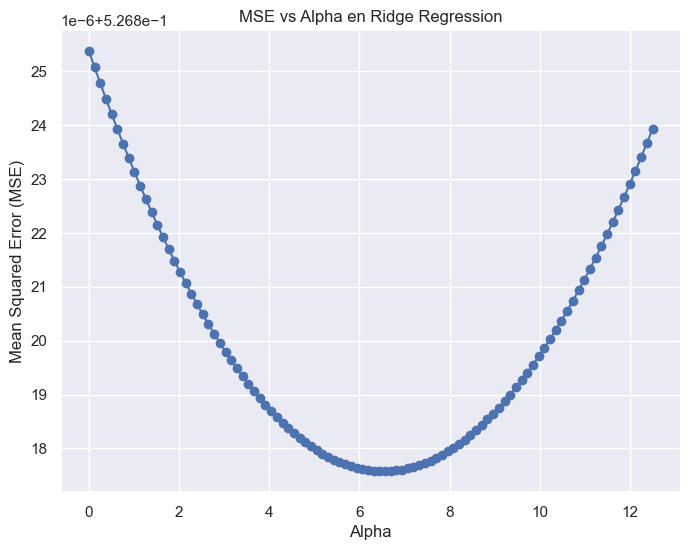

In [13]:

# Lista para almacenar los errores cuadráticos medios
mse_values = []

# Iterar sobre cada valor de alpha
for alpha in alpha_values:
    # Definir el modelo Ridge con el valor actual de alpha
    ridge_model = Ridge(alpha=alpha)

    # Calcular el MSE utilizando validación cruzada (scoring = "neg_mean_squared_error")
    mse = cross_val_score(ridge_model, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)

    # Almacenar el promedio del MSE (se multiplica por -1 para hacerlo positivo)
    mse_values.append(-mse.mean())

results_df = pd.DataFrame({
    'Alpha': alpha_values,
    'Mean Squared Error (MSE)': mse_values
      })

# Graficar alpha vs MSE
plt.figure(figsize=(8, 6))
plt.plot(alpha_values, mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Alpha en Ridge Regression')
plt.grid(True)
plt.show()


In [14]:
# Encontrar el índice del menor MSE
min_mse_index = results_df['Mean Squared Error (MSE)'].idxmin()

# Encontrar el valor de alpha correspondiente al menor MSE
best_alpha = results_df.iloc[min_mse_index]['Alpha']
best_mse = results_df.iloc[min_mse_index]['Mean Squared Error (MSE)']
best_mae = mean_absolute_error(y_test, y_pred)

# Imprimir el valor de alpha y el MSE correspondiente
print(f"El valor óptimo de Alpha es: {best_alpha}")
print(f"El menor MSE es: {best_mse}")
print(f"El menor MAE es: {best_mae}")

NameError: name 'y_pred' is not defined

# 3. Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su respuesta.

# 4. Calcular las métricas de MSE, MAE y R2 del set de evaluación.

In [ ]:


# 1. Crear una instancia del modelo de Regresión Lineal
linear_model = LinearRegression()

# 2. Ajustar el modelo con los datos de entrenamiento
linear_model.fit(X_train_scaled, y_train)

# 3. Hacer predicciones en el conjunto de prueba
y_pred = linear_model.predict(X_test_scaled)

# 4. Evaluar el modelo
# Calcular el MAE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)  # Error cuadrático medio
r2 = r2_score(y_test, y_pred)  # R^2 score (coeficiente de determinación)

# 5. Mostrar los resultados
print("Coeficientes del modelo:", linear_model.coef_)
print("----------------------")
print("Intercepto del modelo:", linear_model.intercept_)
print(f"Mean Absolute Error (MAE): {mae}")
print("Error cuadrático medio (MSE):", mse)
print("R^2 Score:", r2)
print("----------------------")

# Opción adicional: Si deseas ver las predicciones en comparación con los valores reales
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
print(comparison.head())  # Mostrar las primeras 5 predicciones comparadas con los valores reales


Coeficientes del modelo: [ 8.49221760e-01  1.22119309e-01 -2.99558449e-01  3.48409673e-01
 -8.84488134e-04 -4.16980388e-02 -8.93855649e-01 -8.68616688e-01]
----------------------
Intercepto del modelo: 2.0692396089424165
Mean Absolute Error (MAE): 0.5272474538305955
Error cuadrático medio (MSE): 0.5305677824766752
R^2 Score: 0.5957702326061664
----------------------
        Actual  Predicted
20046  0.47700   0.726049
3024   0.45800   1.767434
15663  5.00001   2.710922
20484  2.18600   2.835147
9814   2.78000   2.606958


#1. Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o directamente graficar usando un mapa de calor.

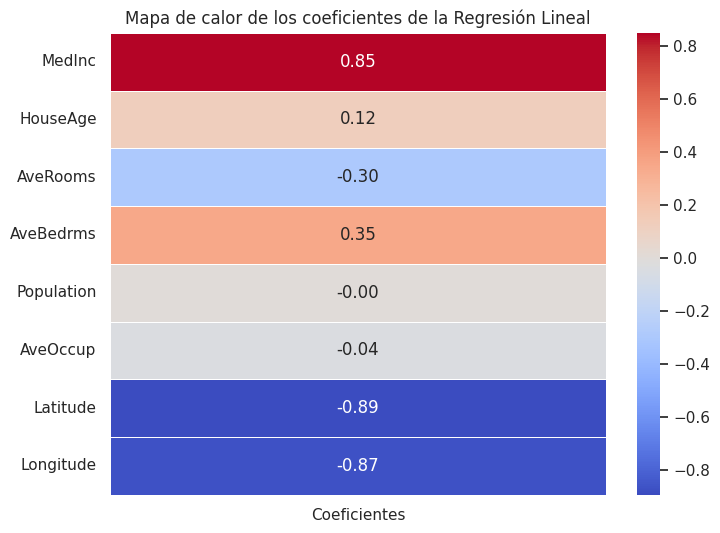

In [ ]:
# 5. Extraer los coeficientes del modelo
coefficients = linear_model.coef_

# 6. Crear un DataFrame para almacenar los coeficientes con el nombre de los atributos
coef_df = pd.DataFrame(coefficients, index=X.columns, columns=['Coeficientes'])

# 7. Graficar un mapa de calor de los coeficientes
plt.figure(figsize=(8, 6))
sns.heatmap(coef_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Mapa de calor de los coeficientes de la Regresión Lineal")
plt.show()

**Population y AveOccup son los atributos que menos influyen en la prediccion**

#2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin entrar en pruebas de hipótesis?

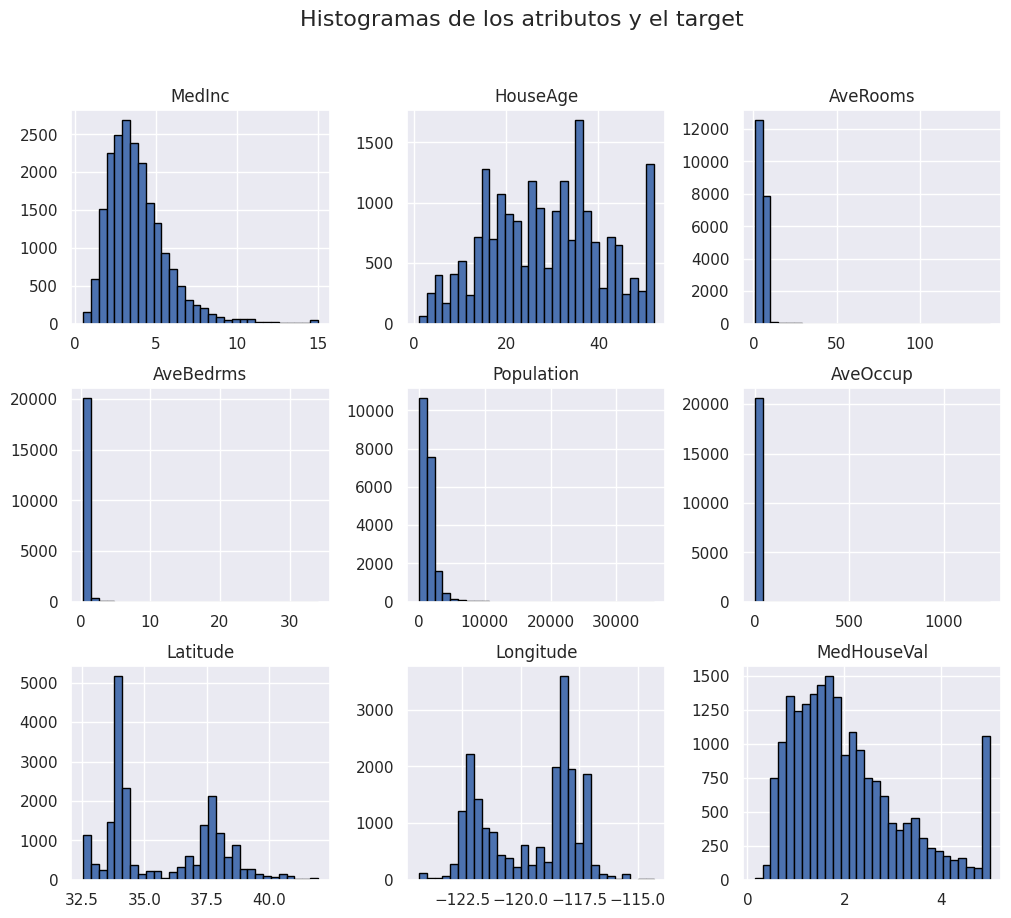

In [ ]:
# Asumimos que df_california ya ha sido creado con X (características) y y (target)
# df_california = pd.concat([X, y], axis=1)

# 1. Crear un histograma para cada columna del DataFrame
df_california.hist(bins=30, figsize=(12, 10), edgecolor='black')
plt.suptitle("Histogramas de los atributos y el target", fontsize=16)
plt.show()

MedInc, HouseAge y MedHouseVal tienen distribuciones en forma de campana.

AveRoom, AveBedrms, Polulation, AveOccup No habria distribucion parecieran valores constantes

Latitud y Longitud pareciera que ubieran 2 ubicaciones o ciudades principales

#6. Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?

Regresión Lineal: Es un modelo sin regularización. Intenta ajustar los datos con la menor suma de errores cuadrados posible.

Ridge: Es una variante de la regresión lineal que incluye regularización L2, lo que le permite penalizar coeficientes grandes para evitar el sobreajuste (overfitting). K-Fold Cross Validation te permite validar el modelo en diferentes subconjuntos de datos, proporcionando una evaluación más robusta.